# Problem Definition & Notes
- Objective
    - Build ML model to predict delivery time
- Core ML Problem
    - Regression Problem
- Evaluation Metric
    - RMSE
- Data Processing
    - Import Data
    - ETL
    - Perform EDA
    - Train-Test Split
    - Data cleansing
    - Feature Engineering
    - Feature Selection
    - Feature scaling/encoding
- Model Architecture
    - Baseline Model
    - ML Model
    - Loss Function
    - Cross-Validation Technique
- Offline Evaluation
    - Evaluate on Test Set (aggregated metric)
    - Evaluate ML model & baseline model
    - Evalaute various segments of data

# Import Libraries

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
import optuna

# Define Functions

In [2]:
def import_data(filepath: str) -> pd.DataFrame:
    """
    Load data from CSV
    """

    try:
        df = pd.read_csv(filepath)
        print('Data loaded to Pandas dataframe')
        return df
    
    except Exception as e:
        print(f"Failed to load data: {e}")

# Import Data

In [ ]:
df_raw_data = import_data("/Users/ani/Projects/7_SKIP_interview_practice/data/uber-eats-deliveries.csv")
df_raw_data.head()

Data loaded to Pandas dataframe


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


# ETL

In [4]:
# format column names (lowercase, remove spaces, remove special characters)
df_etl_data = df_raw_data.copy()
df_etl_data.columns = df_etl_data.columns.str.lower()
df_etl_data.columns = df_etl_data.columns.str.replace(' ', '').str.replace('(', '_').str.replace(')', '')
df_etl_data.head()

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [5]:
# convert column types to relevant types (str, float, datetime)
df_etl_data['delivery_person_age'] = df_etl_data['delivery_person_age'].astype(float)
df_etl_data['delivery_person_ratings'] = df_etl_data['delivery_person_ratings'].astype(float)
df_etl_data['order_date'] = pd.to_datetime(df_etl_data['order_date'], errors='coerce').dt.strftime("%Y-%m-%d")
df_etl_data['time_orderd'] = pd.to_datetime(df_etl_data['time_orderd'], errors='coerce').dt.strftime("%H:%M:%S")
df_etl_data['time_order_picked'] = pd.to_datetime(df_etl_data['time_order_picked'], errors='coerce').dt.strftime("%H:%M:%S")
df_etl_data['multiple_deliveries'] = df_etl_data['multiple_deliveries'].astype(float)
df_etl_data['time_taken_min'] = df_etl_data['time_taken_min'].str.replace('(min) ', '')
df_etl_data['time_taken_min'] = df_etl_data['time_taken_min'].astype(int)
df_etl_data

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/2234545209.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_etl_data['order_date'] = pd.to_datetime(df_etl_data['order_date'], errors='coerce').dt.strftime("%Y-%m-%d")
/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/2234545209.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_etl_data['time_orderd'] = pd.to_datetime(df_etl_data['time_orderd'], errors='coerce').dt.strftime("%H:%M:%S")
/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/2234545209.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a forma

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32
45589,0xd641,AGRRES16DEL01,21.0,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36
45590,0x4f8d,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16
45591,0x5eee,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26


In [6]:
# remove spaces
for col in df_etl_data.select_dtypes(object):
    df_etl_data[col] = df_etl_data[col].str.strip()

In [7]:
# check for ID, Delivery_person_ID length
print(df_etl_data['delivery_person_id'].str.len().value_counts())
print('')
print(df_etl_data['id'].str.len().value_counts())

delivery_person_id
13    23857
14    14634
15     3708
16     3239
17      155
Name: count, dtype: int64

id
6    43121
5     2472
Name: count, dtype: int64


In [8]:
# replace "NaN" with np.nan
df_etl_data = df_etl_data.replace('NaN', np.nan, regex=False)

In [9]:
# lower case and remove spaces in values
lower_cols = df_etl_data.select_dtypes(object).drop(['id', 'delivery_person_id', 'order_date', 'time_orderd', 'time_order_picked'], axis=1).columns.tolist()
df_etl_data[lower_cols] = df_etl_data[lower_cols].apply(lambda x: x.str.lower().str.strip().str.replace(' ', '').str.replace('-', '_'))

df_etl_data

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,conditionssunny,high,2,snack,motorcycle,0.0,no,urban,24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,conditionsstormy,jam,2,snack,scooter,1.0,no,metropolitian,33
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,conditionssandstorms,low,0,drinks,motorcycle,1.0,no,urban,26
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,conditionssunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,conditionscloudy,high,1,snack,scooter,1.0,no,metropolitian,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,conditionswindy,high,1,meal,motorcycle,0.0,no,metropolitian,32
45589,0xd641,AGRRES16DEL01,21.0,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,conditionswindy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36
45590,0x4f8d,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,conditionscloudy,low,1,drinks,scooter,0.0,no,metropolitian,16
45591,0x5eee,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,conditionscloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26


# EDA

In [10]:
df_etl_data.describe()

,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,vehicle_condition,multiple_deliveries,time_taken_min
count,43739.000000,43685.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,44600.000000,45593.000000
mean,29.567137,4.633780,17.017729,70.231332,17.465186,70.845702,1.023359,0.744664,26.294607
std,5.815155,0.334716,8.185109,22.883647,7.335122,21.118812,0.839065,0.572473,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,0.000000,0.000000,10.000000
25%,25.000000,4.500000,12.933284,73.170000,12.988453,73.280000,0.000000,0.000000,19.000000
50%,30.000000,4.700000,18.546947,75.898497,18.633934,76.002574,1.000000,1.000000,26.000000
75%,35.000000,4.900000,22.728163,78.044095,22.785049,78.107044,2.000000,1.000000,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000


In [11]:
df_etl_data.isna().sum()

id                                0
delivery_person_id                0
delivery_person_age            1854
delivery_person_ratings        1908
restaurant_latitude               0
restaurant_longitude              0
delivery_location_latitude        0
delivery_location_longitude       0
order_date                        0
time_orderd                    1731
time_order_picked                 0
weatherconditions                 0
road_traffic_density            601
vehicle_condition                 0
type_of_order                     0
type_of_vehicle                   0
multiple_deliveries             993
festival                        228
city                           1200
time_taken_min                    0
dtype: int64

city
metropolitian    [Axes(0.125,0.11;0.775x0.77)]
semi_urban       [Axes(0.125,0.11;0.775x0.77)]
urban            [Axes(0.125,0.11;0.775x0.77)]
Name: time_taken_min, dtype: object

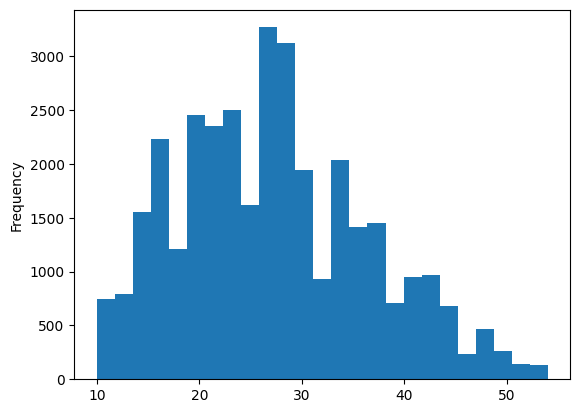

In [12]:
# Histogram of delivery time
df_etl_data.groupby('city')['time_taken_min'].plot(kind='hist', bins=25, subplots=True)

In [13]:
df_etl_data.groupby('city', as_index=False)['time_taken_min'].describe()

,city,count,mean,std,min,25%,50%,75%,max
0,metropolitian,34093.0,27.315226,9.184435,10.0,20.0,27.0,33.0,54.0
1,semi_urban,164.0,49.731707,2.693089,44.0,48.0,49.0,52.0,54.0
2,urban,10136.0,22.984017,8.866011,10.0,16.0,22.0,28.0,54.0


In [14]:
df_etl_data.groupby('city', as_index=False)['time_taken_min'].count()

,city,time_taken_min
0,metropolitian,34093
1,semi_urban,164
2,urban,10136


In [15]:
(len(df_etl_data.dropna())/len(df_etl_data)) * 100

90.73322659180137

In [16]:
Q1 = df_etl_data['time_taken_min'].quantile(0.25) 
Q3 = df_etl_data['time_taken_min'].quantile(0.75)
IQR = Q3-Q1

In [17]:
df_etl_data[df_etl_data['time_taken_min'] < Q1 - 1.5*IQR]

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min


In [18]:
df_etl_data[df_etl_data['time_taken_min'] > Q3 + 1.5*IQR].describe()

,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,vehicle_condition,multiple_deliveries,time_taken_min
count,253.000000,253.000000,270.000000,270.000000,270.000000,270.000000,270.000000,267.000000,270.000000
mean,32.280632,4.489328,17.008850,68.201081,17.628196,70.611970,0.055556,1.543071,53.044444
std,4.982937,0.365155,8.715594,28.316503,7.584264,21.868842,0.405202,1.026445,0.793718
min,20.000000,3.500000,-30.372202,-80.257221,0.040000,0.040000,0.000000,0.000000,52.000000
25%,30.000000,4.200000,12.318029,73.166545,12.415149,73.841704,0.000000,1.000000,52.000000
50%,33.000000,4.600000,18.578326,75.891032,18.672450,76.001032,0.000000,1.000000,53.000000
75%,36.000000,4.800000,22.748060,77.645660,22.860440,78.103026,0.000000,3.000000,54.000000
max,39.000000,5.000000,30.905562,88.400467,31.003081,88.530467,3.000000,3.000000,54.000000


# Data Pre-Processing

In [19]:
df_processed = df_etl_data.copy()

In [20]:
df_processed = df_processed.sort_values(['order_date', 'time_orderd']).reset_index(drop=True)
df_processed

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0xd152,BHPRES15DEL03,38.0,4.8,23.234249,77.434007,23.294249,77.494007,2022-02-11,00:00:00,00:10:00,conditionsfog,low,1,meal,scooter,1.0,no,urban,17
1,0xc401,LUDHRES11DEL02,25.0,4.6,30.893081,75.821495,30.943081,75.871495,2022-02-11,00:00:00,00:05:00,conditionssandstorms,low,1,snack,scooter,0.0,no,metropolitian,12
2,0xd300,KOCRES05DEL03,39.0,4.6,9.970717,76.285447,10.030717,76.345447,2022-02-11,00:00:00,00:05:00,conditionswindy,low,2,snack,motorcycle,1.0,no,metropolitian,27
3,0xc614,DEHRES04DEL03,36.0,4.9,30.340722,78.060221,30.370722,78.090221,2022-02-11,00:00:00,00:10:00,conditionssunny,low,1,drinks,motorcycle,0.0,no,urban,11
4,0xcb30,AGRRES08DEL01,22.0,4.3,27.160934,78.044095,27.170934,78.054095,2022-02-11,08:10:00,08:20:00,conditionswindy,low,0,drinks,motorcycle,0.0,no,urban,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x1396,HYDRES03DEL01,NaN,NaN,17.422819,78.449578,17.492819,78.519578,2022-04-06,NaN,22:50:00,conditionsfog,low,2,drinks,scooter,1.0,no,urban,25
45589,0x4ca,MYSRES05DEL01,NaN,NaN,12.323978,76.627961,12.433978,76.737961,2022-04-06,NaN,19:25:00,conditionsfog,jam,1,meal,motorcycle,1.0,no,urban,41
45590,0x4fe,SURRES04DEL03,NaN,NaN,-21.173493,-72.801953,21.263493,72.891953,2022-04-06,NaN,19:15:00,conditionsstormy,jam,1,drinks,scooter,1.0,no,metropolitian,23
45591,0x576,HYDRES11DEL02,NaN,NaN,-17.430448,78.418213,17.560448,78.548213,2022-04-06,NaN,22:45:00,conditionsfog,low,2,meal,scooter,1.0,no,metropolitian,37


##### Train-Test Split

In [41]:
df_train = df_processed[0:int(0.8*len(df_processed))].copy()
df_test = df_processed[int(0.8*len(df_processed)):].copy()

##### Imput Missing Values

In [42]:
print(df_train.isna().sum())
print('')
print(df_test.isna().sum())

id                                0
delivery_person_id                0
delivery_person_age            1465
delivery_person_ratings        1519
restaurant_latitude               0
restaurant_longitude              0
delivery_location_latitude        0
delivery_location_longitude       0
order_date                        0
time_orderd                    1380
time_order_picked                 0
weatherconditions                 0
road_traffic_density            474
vehicle_condition                 0
type_of_order                     0
type_of_vehicle                   0
multiple_deliveries             796
festival                        176
city                            959
time_taken_min                    0
dtype: int64

id                               0
delivery_person_id               0
delivery_person_age            389
delivery_person_ratings        389
restaurant_latitude              0
restaurant_longitude             0
delivery_location_latitude       0
delivery_location_lon

In [43]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

mean_impute_columns = ['delivery_person_age']
median_impute_columns = ['delivery_person_ratings']
mode_impute_columns = ['time_orderd', 'road_traffic_density', 'multiple_deliveries', 'festival', 'city']

for col in mean_impute_columns:
    df_train[col] = imp_mean.fit_transform(df_train[[col]]).ravel()
    df_test[col] = imp_mean.transform(df_test[[col]]).ravel()

for col in median_impute_columns:
    df_train[col] = imp_median.fit_transform(df_train[[col]]).ravel()
    df_test[col] = imp_median.transform(df_test[[col]]).ravel()

for col in mode_impute_columns:
    df_train[col] = imp_mode.fit_transform(df_train[[col]]).ravel()
    df_test[col] = imp_mode.transform(df_test[[col]]).ravel()

##### Feature Engineering

In [44]:
# day of week (1-7)
# hour of day (0-23)
# distance
# km/hr per driver

In [45]:
def calculate_distance(lat1: pd.Series, lon1: pd.Series, 
                       lat2: pd.Series, lon2: pd.Series) -> pd.Series:
    """Calculate distance using Haversine formula."""
    R = 6371  # Earth radius in km
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [46]:
df_train['day_of_week'] = pd.to_datetime(df_train['order_date']).dt.day_of_week
df_train['hour_of_day'] = pd.to_datetime(df_train['time_orderd']).dt.hour
df_train['distance'] = calculate_distance(df_train['restaurant_latitude'], df_train['restaurant_longitude'], df_train['delivery_location_latitude'], df_train['delivery_location_longitude'])

df_driver_speed = df_train.groupby(['delivery_person_id'], as_index=False)[['distance', 'time_taken_min']].sum()
df_driver_speed['driver_speed'] = df_driver_speed['distance'] / df_driver_speed['time_taken_min']

df_train['driver_avg_rating'] = df_train.groupby('delivery_person_id', as_index=False)['delivery_person_ratings'].transform('mean')

df_train = pd.merge(df_train, df_driver_speed[['delivery_person_id', 'driver_speed']], how='left', on='delivery_person_id')
df_train

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/1862984941.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train['hour_of_day'] = pd.to_datetime(df_train['time_orderd']).dt.hour


,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,...,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min,day_of_week,hour_of_day,distance,driver_avg_rating,driver_speed
0,0xd152,BHPRES15DEL03,38.0,4.8,23.234249,77.434007,23.294249,77.494007,2022-02-11,00:00:00,...,scooter,1.0,no,urban,17,4,0,9.059752,4.742857,0.385521
1,0xc401,LUDHRES11DEL02,25.0,4.6,30.893081,75.821495,30.943081,75.871495,2022-02-11,00:00:00,...,scooter,0.0,no,metropolitian,12,4,0,7.325368,4.468750,0.395355
2,0xd300,KOCRES05DEL03,39.0,4.6,9.970717,76.285447,10.030717,76.345447,2022-02-11,00:00:00,...,motorcycle,1.0,no,metropolitian,27,4,0,9.363795,4.590909,13.614858
3,0xc614,DEHRES04DEL03,36.0,4.9,30.340722,78.060221,30.370722,78.090221,2022-02-11,00:00:00,...,motorcycle,0.0,no,urban,11,4,0,4.406103,4.653333,0.442353
4,0xcb30,AGRRES08DEL01,22.0,4.3,27.160934,78.044095,27.170934,78.054095,2022-02-11,08:10:00,...,motorcycle,0.0,no,urban,27,4,8,1.488329,4.790909,0.259195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36469,0x21dc,INDORES07DEL02,29.0,4.8,22.722634,75.886959,22.802634,75.966959,2022-03-29,19:30:00,...,scooter,1.0,no,metropolitian,29,1,19,12.100288,4.602326,4.950911
36470,0x724e,COIMBRES18DEL01,32.0,4.4,11.020910,76.940432,11.090910,77.010432,2022-03-29,19:30:00,...,motorcycle,1.0,no,metropolitian,50,1,19,10.906065,4.581395,0.300482
36471,0x304b,MUMRES010DEL01,37.0,4.3,19.003517,72.827650,19.113517,72.937650,2022-03-29,19:30:00,...,scooter,2.0,no,metropolitian,47,1,19,16.830461,4.582927,4.005981
36472,0x497b,HYDRES16DEL01,36.0,4.2,17.440827,78.393391,17.510827,78.463391,2022-03-29,19:30:00,...,scooter,1.0,no,metropolitian,44,1,19,10.756698,4.650000,3.652290


In [47]:
df_test['day_of_week'] = pd.to_datetime(df_test['order_date']).dt.day_of_week
df_test['hour_of_day'] = pd.to_datetime(df_test['time_orderd']).dt.hour
df_test['distance'] = calculate_distance(df_test['restaurant_latitude'], df_test['restaurant_longitude'], df_test['delivery_location_latitude'], df_test['delivery_location_longitude'])

df_driver_speed = df_test.groupby(['delivery_person_id'], as_index=False)[['distance', 'time_taken_min']].sum()
df_driver_speed['driver_speed'] = df_driver_speed['distance'] / df_driver_speed['time_taken_min']

df_test['driver_avg_rating'] = df_test.groupby('delivery_person_id', as_index=False)['delivery_person_ratings'].transform('mean')

df_test = pd.merge(df_test, df_driver_speed[['delivery_person_id', 'driver_speed']], how='left', on='delivery_person_id')
df_test

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/427671267.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test['hour_of_day'] = pd.to_datetime(df_test['time_orderd']).dt.hour


,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,...,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min,day_of_week,hour_of_day,distance,driver_avg_rating,driver_speed
0,0xbd01,PUNERES09DEL03,30.000000,4.6,18.536562,73.896485,18.626562,73.986485,2022-03-29,19:30:00,...,motorcycle,0.0,no,metropolitian,46,1,19,13.788852,4.760000,0.389211
1,0x5980,PUNERES07DEL01,28.000000,4.0,18.546947,73.900626,18.616947,73.970626,2022-03-29,19:30:00,...,motorcycle,0.0,no,metropolitian,38,1,19,10.724652,4.718750,0.353259
2,0x6ff3,MUMRES18DEL01,28.000000,4.7,19.109300,72.825451,19.179300,72.895451,2022-03-29,19:30:00,...,motorcycle,0.0,no,urban,24,1,19,10.707675,4.678571,0.316881
3,0x4a6f,VADRES15DEL02,35.000000,3.5,0.000000,0.000000,0.080000,0.080000,2022-03-29,19:30:00,...,scooter,1.0,no,urban,34,1,19,12.580268,4.520000,0.433432
4,0x4f5d,COIMBRES03DEL01,37.000000,4.9,11.025083,77.015393,11.095083,77.085393,2022-03-29,19:30:00,...,motorcycle,1.0,no,urban,22,1,19,10.905989,4.686667,0.367653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9114,0x1396,HYDRES03DEL01,29.567968,4.7,17.422819,78.449578,17.492819,78.519578,2022-04-06,17:55:00,...,scooter,1.0,no,urban,25,2,17,10.757205,4.635714,0.361336
9115,0x4ca,MYSRES05DEL01,29.567968,4.7,12.323978,76.627961,12.433978,76.737961,2022-04-06,17:55:00,...,motorcycle,1.0,no,urban,41,2,17,17.097973,4.457143,0.326182
9116,0x4fe,SURRES04DEL03,29.567968,4.7,-21.173493,-72.801953,21.263493,72.891953,2022-04-06,17:55:00,...,scooter,1.0,no,metropolitian,23,2,17,16466.194147,4.654545,57.490997
9117,0x576,HYDRES11DEL02,29.567968,4.7,-17.430448,78.418213,17.560448,78.548213,2022-04-06,17:55:00,...,scooter,1.0,no,metropolitian,37,2,17,3890.836127,4.673333,9.642759


In [48]:
assert df_train.isna().sum().sum() == 0, 'Missing Values in dataset'

##### Feature Selection

In [49]:
df_train.select_dtypes([float, int]).drop(['time_taken_min', 'delivery_location_longitude', 'restaurant_longitude', 'delivery_location_latitude', 'restaurant_latitude'], axis=1)

,delivery_person_age,delivery_person_ratings,vehicle_condition,multiple_deliveries,day_of_week,hour_of_day,distance,driver_avg_rating,driver_speed
0,38.0,4.8,1,1.0,4,0,9.059752,4.742857,0.385521
1,25.0,4.6,1,0.0,4,0,7.325368,4.468750,0.395355
2,39.0,4.6,2,1.0,4,0,9.363795,4.590909,13.614858
3,36.0,4.9,1,0.0,4,0,4.406103,4.653333,0.442353
4,22.0,4.3,0,0.0,4,8,1.488329,4.790909,0.259195
...,...,...,...,...,...,...,...,...,...
36469,29.0,4.8,1,1.0,1,19,12.100288,4.602326,4.950911
36470,32.0,4.4,0,1.0,1,19,10.906065,4.581395,0.300482
36471,37.0,4.3,1,2.0,1,19,16.830461,4.582927,4.005981
36472,36.0,4.2,2,1.0,1,19,10.756698,4.650000,3.652290


In [50]:
features = df_train.select_dtypes([float, int]).drop(['delivery_person_ratings', 'time_taken_min', 'delivery_location_longitude', 'restaurant_longitude', 'delivery_location_latitude', 'restaurant_latitude'], axis=1)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) 
                   for i in range(features.shape[1])]

# VIF > 10 indicates high collinearity
print(vif_data.sort_values('VIF', ascending=False))

               Feature        VIF
6    driver_avg_rating  44.648048
0  delivery_person_age  28.115714
4          hour_of_day  14.489678
3          day_of_week   3.375855
2  multiple_deliveries   2.819184
1    vehicle_condition   2.530737
7         driver_speed   1.235913
5             distance   1.070499


In [51]:
df_baseline_train = df_train.copy()
df_baseline_test = df_test.copy()

##### Feature Scaling/Encoding

In [52]:
scaler = StandardScaler()
scaled_cols = df_train.drop(['time_taken_min'], axis=1).select_dtypes([float, int]).columns.tolist()

df_train[scaled_cols] = scaler.fit_transform(df_train[scaled_cols])
df_test[scaled_cols] = scaler.transform(df_test[scaled_cols])

In [53]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cols = df_train.drop(['id', 'delivery_person_id', 'order_date', 'time_orderd', 'time_order_picked'], axis=1).select_dtypes(object).columns.tolist()

encoded_array = encoder.fit_transform(df_train[encoded_cols])
features_names = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(columns=features_names, data=encoded_array)
df_train = pd.concat([df_train.drop(encoded_cols, axis=1), df_encoded], axis=1)

In [54]:
encoded_array = encoder.transform(df_test[encoded_cols])
features_names = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(columns=features_names, data=encoded_array)
df_test = pd.concat([df_test.drop(encoded_cols, axis=1), df_encoded], axis=1)

In [55]:
features = df_train.drop(['time_order_picked', 'time_taken_min', 'id', 'delivery_person_id', 'delivery_person_ratings', 'restaurant_latitude', 'restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude', 'order_date', 'time_orderd'], axis=1).columns.tolist()
target = ['time_taken_min']

df_train = df_train[features + target]
df_test = df_test[features + target]

df_train_x = df_train[features]
df_train_y = df_train[target]

df_test_x = df_test[features]
df_test_y = df_test[target] 

# Model Architecture

##### Baseline Model

In [71]:
df_baseline_train_model = df_baseline_train.groupby('city', as_index=False)[['distance', 'time_taken_min']].mean()
# df_baseline_train_model['distance_per_min'] = df_baseline_train_model['distance'] / df_baseline_train_model['time_taken_min']
df_baseline_train_model

,city,distance,time_taken_min
0,metropolitian,102.498199,27.115770
1,semi_urban,46.792261,49.880952
2,urban,109.377163,23.009169


In [72]:
df_baseline_test_model = df_baseline_test[['id', 'distance', 'city']].merge(df_baseline_train_model[['city', 'time_taken_min']], how='left', on='city')
# df_baseline_test_model['time_taken_min'] = df_baseline_test_model['distance'] / df_baseline_test_model['distance_per_min'] 
df_baseline_test_model = df_baseline_test_model.rename(columns={'time_taken_min': 'baseline_time_taken_min'})
df_baseline_test_model

,id,distance,city,baseline_time_taken_min
0,0xbd01,13.788852,metropolitian,27.115770
1,0x5980,10.724652,metropolitian,27.115770
2,0x6ff3,10.707675,urban,23.009169
3,0x4a6f,12.580268,urban,23.009169
4,0x4f5d,10.905989,urban,23.009169
...,...,...,...,...
9114,0x1396,10.757205,urban,23.009169
9115,0x4ca,17.097973,urban,23.009169
9116,0x4fe,16466.194147,metropolitian,27.115770
9117,0x576,3890.836127,metropolitian,27.115770


##### Gradient Boosted Decision Tree

In [172]:
# Loss Function
# Cross Validation & hyper-parameter tuning

In [ ]:
def objective(trial):
    # Cross validation splits
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbose': -1
    }
    
    rmse_scores = []
    
    # K-fold cross validation
    for train_idx, valid_idx in kf.split(df_train_x):
        X_tr, X_val = df_train_x.iloc[train_idx], df_train_x.iloc[valid_idx]
        y_tr, y_val = df_train_y.iloc[train_idx], df_train_y.iloc[valid_idx]
        
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_valid],
            callbacks=[lgb.early_stopping(10, verbose=False)],
        )
        
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

[I 2025-11-30 13:20:33,858] A new study created in memory with name: no-name-2a4ee399-97f5-4697-b28e-740eb4a2ad89
[I 2025-11-30 13:20:44,435] Trial 0 finished with value: 4.175216669610743 and parameters: {'n_estimators': 570, 'num_leaves': 205, 'max_depth': 26, 'min_child_samples': 41, 'subsample': 0.9003831225911678, 'colsample_bytree': 0.8963023454461287}. Best is trial 0 with value: 4.175216669610743.
[I 2025-11-30 13:20:57,243] Trial 1 finished with value: 4.19253488958398 and parameters: {'n_estimators': 325, 'num_leaves': 245, 'max_depth': 32, 'min_child_samples': 87, 'subsample': 0.775673115468135, 'colsample_bytree': 0.8130396929724388}. Best is trial 0 with value: 4.175216669610743.
[I 2025-11-30 13:21:01,978] Trial 2 finished with value: 4.321861318094068 and parameters: {'n_estimators': 726, 'num_leaves': 196, 'max_depth': 6, 'min_child_samples': 59, 'subsample': 0.7535148649165926, 'colsample_bytree': 0.6151946153625044}. Best is trial 0 with value: 4.175216669610743.
[I 2

Number of finished trials: 50
Best trial:
  Value:  4.136719721621898
  Params: 
    n_estimators: 228
    num_leaves: 95
    max_depth: 25
    min_child_samples: 33
    subsample: 0.7993344331727532
    colsample_bytree: 0.8844165209376962


In [173]:
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)

print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-11-30 13:40:23,319] A new study created in memory with name: no-name-d43aa416-91d6-43a1-839a-7ada902bde25
[I 2025-11-30 13:40:28,632] Trial 0 finished with value: 4.1722481051217635 and parameters: {'n_estimators': 146, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 57, 'subsample': 0.8574722754402726, 'colsample_bytree': 0.8628087711701424}. Best is trial 0 with value: 4.1722481051217635.
[W 2025-11-30 13:40:30,786] Trial 1 failed with parameters: {'n_estimators': 671, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.6930048603954926, 'colsample_bytree': 0.8710646073895774} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ani/Projects/7_SKIP_interview_practice/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_92705/1800972

KeyboardInterrupt: 

In [174]:
study.best_params

{'n_estimators': 146,
 'num_leaves': 67,
 'max_depth': 9,
 'min_child_samples': 57,
 'subsample': 0.8574722754402726,
 'colsample_bytree': 0.8628087711701424}

In [150]:
# After study.optimize()
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
})

# Train on full training data
lgb_train = lgb.Dataset(df_train_x, df_train_y)
lgb_valid = lgb.Dataset(df_test_x, df_test_y, reference=lgb_train)

final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_valid],
    callbacks=[lgb.early_stopping(10, verbose=False)],
)

# Use final_model for predictions_tuned
predictions_tuned = final_model.predict(data=df_test_x)
predictions_tuned = df_test_y.merge(pd.DataFrame(predictions_tuned), left_index=True, right_index=True).rename(columns={0: 'predicted_time_taken_min'}).merge(df_baseline_test_model[['distance', 'baseline_time_taken_min']], left_index=True, right_index=True)
predictions_tuned

,time_taken_min,predicted_time_taken_min,distance,baseline_time_taken_min
0,46,40.360582,13.788852,27.115770
1,38,30.761877,10.724652,27.115770
2,24,20.963012,10.707675,23.009169
3,34,33.383026,12.580268,23.009169
4,22,23.054318,10.905989,23.009169
...,...,...,...,...
9114,25,26.449702,10.757205,23.009169
9115,41,36.946686,17.097973,23.009169
9116,23,25.324347,16466.194147,27.115770
9117,37,24.306691,3890.836127,27.115770


In [151]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10,
    'num_iterations': 100,
    'min_data_in_leaf': 10
    }

df_train_lgb = lgb.Dataset(data=df_train_x, label=df_train_y)
df_test_lgb = lgb.Dataset(data=df_test_x, label=df_test_y)

model = lgb.train(params=params, train_set=df_train_lgb)

In [152]:
predictions = model.predict(data=df_test_x)
predictions = df_test_y.merge(pd.DataFrame(predictions), left_index=True, right_index=True).rename(columns={0: 'predicted_time_taken_min'}).merge(df_baseline_test_model[['distance', 'baseline_time_taken_min']], left_index=True, right_index=True)
predictions

,time_taken_min,predicted_time_taken_min,distance,baseline_time_taken_min
0,46,40.616614,13.788852,27.115770
1,38,30.941325,10.724652,27.115770
2,24,20.810954,10.707675,23.009169
3,34,33.175925,12.580268,23.009169
4,22,23.703621,10.905989,23.009169
...,...,...,...,...
9114,25,28.917984,10.757205,23.009169
9115,41,35.045823,17.097973,23.009169
9116,23,24.460325,16466.194147,27.115770
9117,37,22.504500,3890.836127,27.115770


# Evaluate

In [154]:
# Evaluate using RMSE
# Feature importance

<Axes: xlabel='features'>

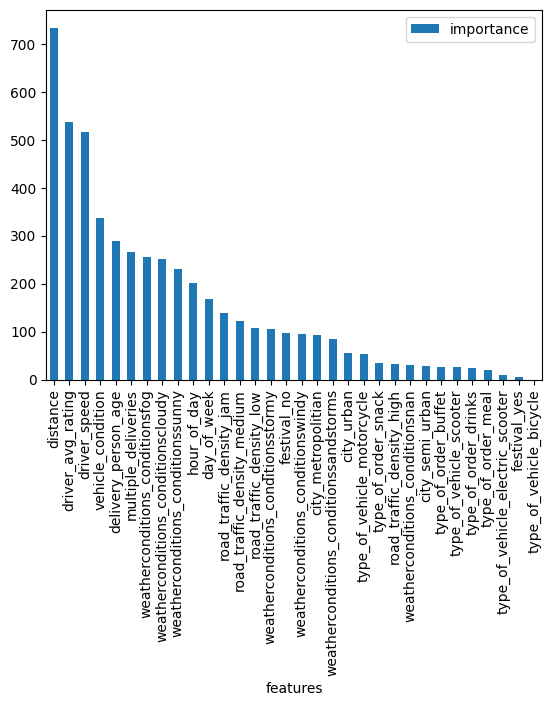

In [155]:
df_feature_importance = pd.DataFrame({
    'features': final_model.feature_name(),
    'importance': final_model.feature_importance()
})
df_feature_importance.sort_values('importance', ascending=False).plot(kind='bar', x='features', y='importance')

<Axes: xlabel='features'>

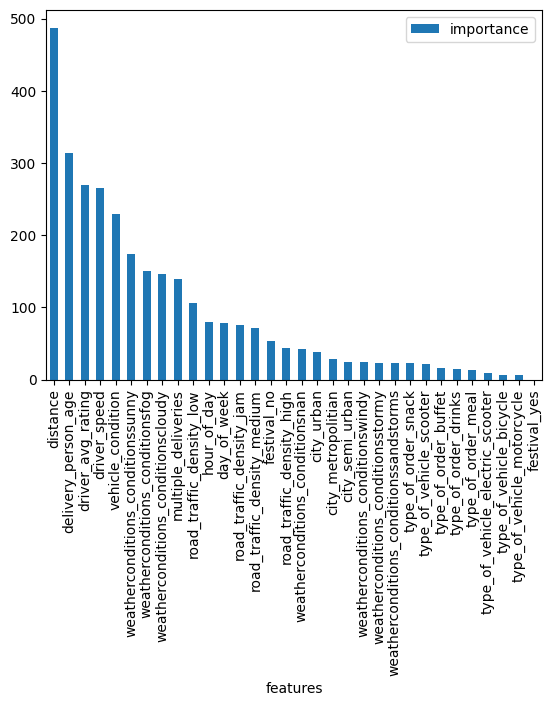

In [157]:
df_feature_importance = pd.DataFrame({
    'features': model.feature_name(),
    'importance': model.feature_importance()
})
df_feature_importance.sort_values('importance', ascending=False).plot(kind='bar', x='features', y='importance')

In [160]:
df_evaluate_tuned = predictions_tuned[['time_taken_min', 'predicted_time_taken_min', 'baseline_time_taken_min']].copy()
df_evaluate_tuned['abs_model_error'] = np.abs(df_evaluate_tuned['time_taken_min'] - df_evaluate_tuned['predicted_time_taken_min'])
df_evaluate_tuned['abs_baseline_error'] = np.abs(df_evaluate_tuned['time_taken_min'] - df_evaluate_tuned['baseline_time_taken_min'])

df_evaluate_tuned['model_error'] = (df_evaluate_tuned['time_taken_min'] - df_evaluate_tuned['predicted_time_taken_min'])
df_evaluate_tuned['baseline_error'] = (df_evaluate_tuned['time_taken_min'] - df_evaluate_tuned['baseline_time_taken_min'])

df_evaluate_tuned

,time_taken_min,predicted_time_taken_min,baseline_time_taken_min,abs_model_error,abs_baseline_error,model_error,baseline_error
0,46,40.360582,27.115770,5.639418,18.884230,5.639418,18.884230
1,38,30.761877,27.115770,7.238123,10.884230,7.238123,10.884230
2,24,20.963012,23.009169,3.036988,0.990831,3.036988,0.990831
3,34,33.383026,23.009169,0.616974,10.990831,0.616974,10.990831
4,22,23.054318,23.009169,1.054318,1.009169,-1.054318,-1.009169
...,...,...,...,...,...,...,...
9114,25,26.449702,23.009169,1.449702,1.990831,-1.449702,1.990831
9115,41,36.946686,23.009169,4.053314,17.990831,4.053314,17.990831
9116,23,25.324347,27.115770,2.324347,4.115770,-2.324347,-4.115770
9117,37,24.306691,27.115770,12.693309,9.884230,12.693309,9.884230


In [163]:
df_evaluate = predictions[['time_taken_min', 'predicted_time_taken_min', 'baseline_time_taken_min']].copy()
df_evaluate['abs_model_error'] = np.abs(df_evaluate['time_taken_min'] - df_evaluate['predicted_time_taken_min'])
df_evaluate['abs_baseline_error'] = np.abs(df_evaluate['time_taken_min'] - df_evaluate['baseline_time_taken_min'])

df_evaluate['model_error'] = (df_evaluate['time_taken_min'] - df_evaluate['predicted_time_taken_min'])
df_evaluate['baseline_error'] = (df_evaluate['time_taken_min'] - df_evaluate['baseline_time_taken_min'])

df_evaluate

,time_taken_min,predicted_time_taken_min,baseline_time_taken_min,abs_model_error,abs_baseline_error,model_error,baseline_error
0,46,40.616614,27.115770,5.383386,18.884230,5.383386,18.884230
1,38,30.941325,27.115770,7.058675,10.884230,7.058675,10.884230
2,24,20.810954,23.009169,3.189046,0.990831,3.189046,0.990831
3,34,33.175925,23.009169,0.824075,10.990831,0.824075,10.990831
4,22,23.703621,23.009169,1.703621,1.009169,-1.703621,-1.009169
...,...,...,...,...,...,...,...
9114,25,28.917984,23.009169,3.917984,1.990831,-3.917984,1.990831
9115,41,35.045823,23.009169,5.954177,17.990831,5.954177,17.990831
9116,23,24.460325,27.115770,1.460325,4.115770,-1.460325,-4.115770
9117,37,22.504500,27.115770,14.495500,9.884230,14.495500,9.884230


In [164]:
baseline_rmse = np.sqrt(np.mean(df_evaluate_tuned['abs_baseline_error'] ** 2))
model_rmse = np.sqrt(np.mean(df_evaluate_tuned['abs_model_error'] ** 2))

print(f'Model RMSE: {model_rmse}')
print(f'Baseline RMSE: {baseline_rmse}')


Model RMSE: 4.160900937213581
Baseline RMSE: 9.184653727159292


In [166]:
baseline_rmse = np.sqrt(np.mean(df_evaluate['abs_baseline_error'] ** 2))
model_rmse = np.sqrt(np.mean(df_evaluate['abs_model_error'] ** 2))

print(f'Model RMSE: {model_rmse}')
print(f'Baseline RMSE: {baseline_rmse}')


Model RMSE: 4.248530127708775
Baseline RMSE: 9.184653727159292


In [170]:
print((len(df_evaluate_tuned[df_evaluate_tuned['model_error'] >= 0]) / len(df_evaluate_tuned)) * 100)
print((len(df_evaluate_tuned[df_evaluate_tuned['model_error'] < 0]) / len(df_evaluate_tuned)) * 100)

48.78824432503564
51.211755674964365


In [171]:
print((len(df_evaluate[df_evaluate['model_error'] >= 0]) / len(df_evaluate)) * 100)
print((len(df_evaluate[df_evaluate['model_error'] < 0]) / len(df_evaluate)) * 100)

48.525057572102206
51.474942427897794


In [122]:
print((len(df_evaluate[df_evaluate['baseline_error'] >= 0]) / len(df_evaluate)) * 100)
print((len(df_evaluate[df_evaluate['baseline_error'] < 0]) / len(df_evaluate)) * 100)

43.76576378988924
56.23423621011076
